# Machine Learning Magic: 
### Filling gaps in streamflow data sets using a Deep Learning Network

In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))

#%matplotlib inline
%matplotlib notebook

import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import datetime
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy
import tensorflow as tf

pd.set_option('display.max_rows', 200)    
np.set_printoptions(suppress=True)


# import function from current working directory
from baseflow_separator import baseflow_separator

Using TensorFlow backend.
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cshul

## Grab data

In [2]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Stream_REPO/workspace/All_consolodated_Q_m3ps.csv"
save_to = os.path.join("..", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

16200025

## process Data


<IPython.core.display.Javascript object>


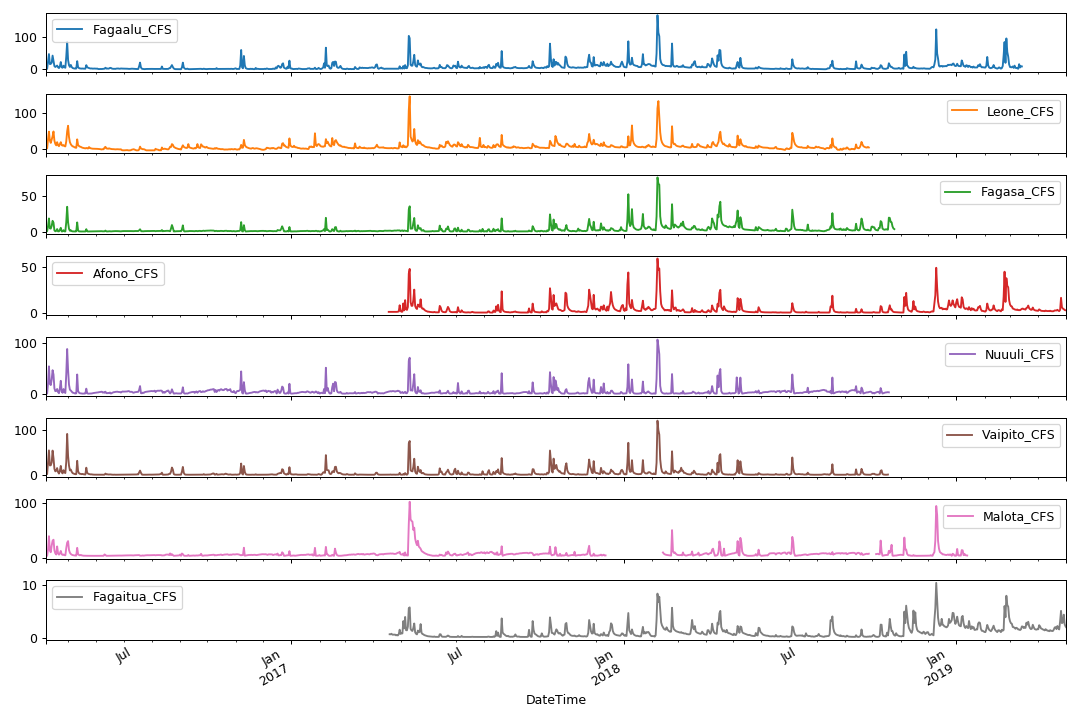

In [3]:
rawdata = pd.read_csv(save_to ,index_col=0,parse_dates=True)

dat = rawdata.resample('D').mean()     # subsample the 15 min data into daily values
dat = dat[10:]                          # this just to cut out some of the beginning days with no streamflows

data = pd.DataFrame(index=dat.index)
for column in dat:
    new_name = column.split("_")[0]+"_CFS"
    data[new_name] = dat[column]*35.314666212661 

data.plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.legend(loc='best')

## Check on correlation between stations


<IPython.core.display.Javascript object>


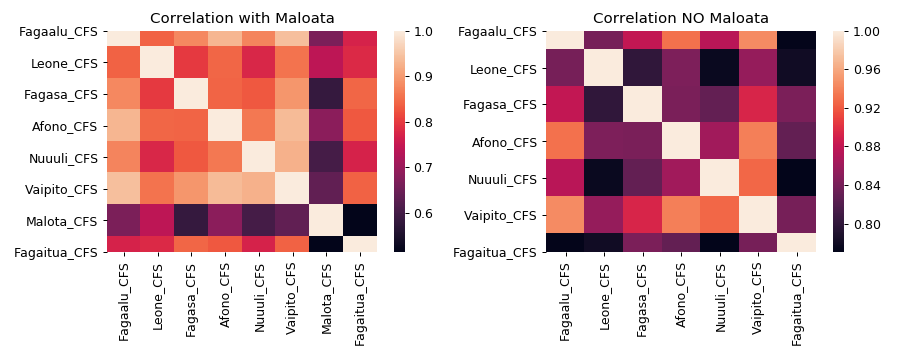

Text(0.5, 1, 'Correlation NO Maloata')

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

corr = data.corr()
sns.heatmap(corr,  xticklabels=data.columns.values, yticklabels=data.columns.values, ax=ax1)
ax1.set_title("Correlation with Maloata")


## remove Maloata from data  new plot due to low correlations
data = data.loc[:, data.columns != 'Malota_CFS']

corr = data.corr()
sns.heatmap(corr,  xticklabels=data.columns.values, yticklabels=data.columns.values, ax=ax2)
plt.tight_layout()
ax2.set_title("Correlation NO Maloata")

# note that unless the data variable is regenerated up above both of these plots will be the same. 

### determine what proportion of data is misssing. This will be used to praramaterize the validation exercise
formerly used
data_date_range = data.index.max()-data.index.min()      #The total number of days in total data record, including gaps
pct_existing_list=[]

for i in data:                               # for each station name e.g "Fagaalu_CFS"
    tempframe = data[i]
    tempframe = tempframe.dropna()                                   
    temp_day_count = tempframe.index.max()-tempframe.index.min()     # find the number of days of actual data
    pct_existing = temp_day_count/data_date_range                    
    pct_existing_list.append(pct_existing)
    
Ave_amount_existing_data = np.mean(pct_existing_list)
print("the amount of data in each station ranges from {:.2f}%  to {:.2f}%, average is {:.2f}%".format(min(pct_existing_list), max(pct_existing_list), Ave_amount_existing_data))


In [5]:
# for now use 50%
Ave_amount_existing_data = .5

<IPython.core.display.Javascript object>


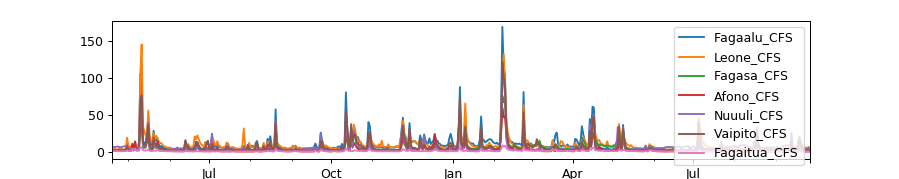

In [6]:
# just select perfect no gap dataset 
data_perfect = data.dropna()

data_perfect.plot(subplots=False, figsize=(10, 2))
plt.legend(loc=1)

# Monstor loop to get validation stats on all stations

gap filling for station Fagaalu_CFS
Training with stations ['Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


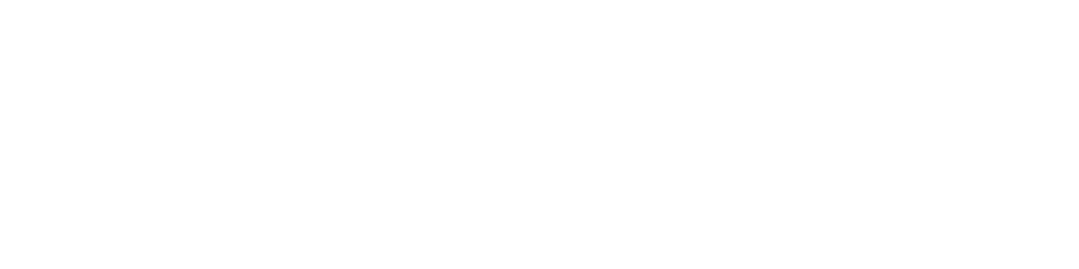

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


<IPython.core.display.Javascript object>


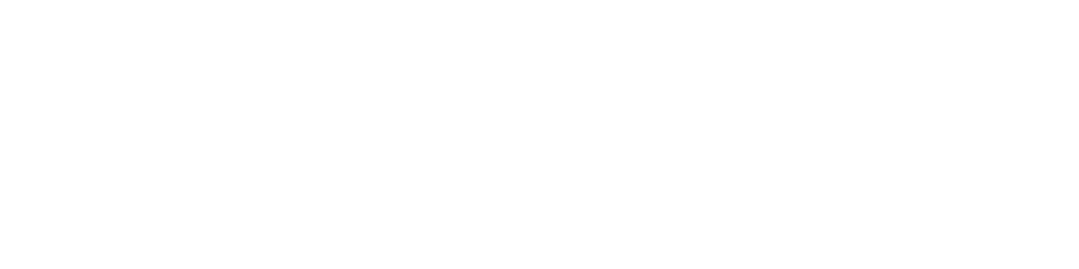

<IPython.core.display.Javascript object>


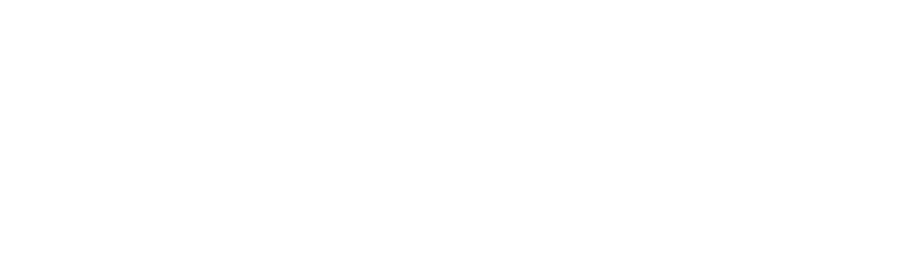

RMSE Error=5.06    r2=0.97    slope=0.78    Std_RMSE=0.51


gap filling for station Leone_CFS
Training with stations ['Fagaalu_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


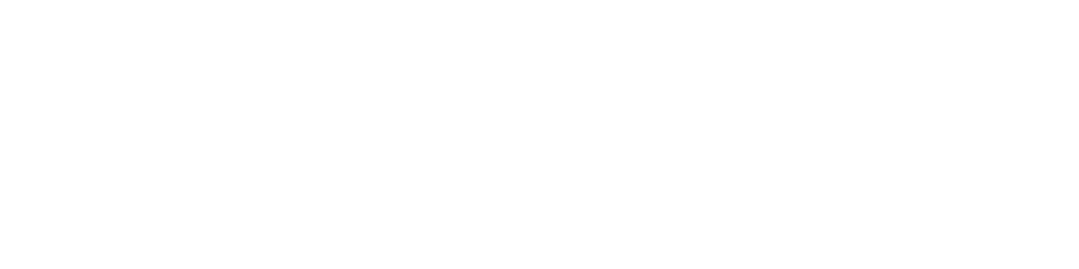

<IPython.core.display.Javascript object>


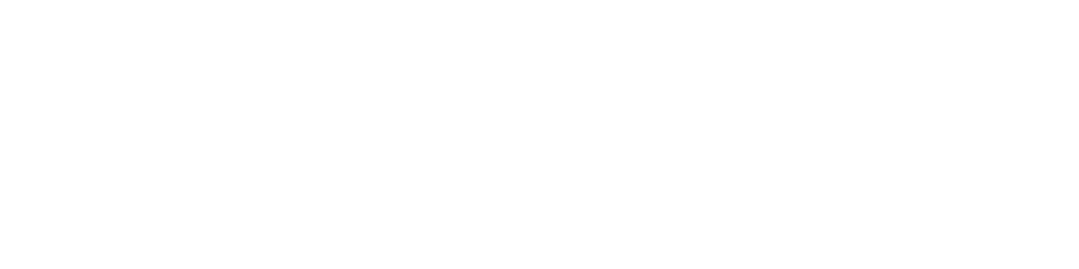

<IPython.core.display.Javascript object>


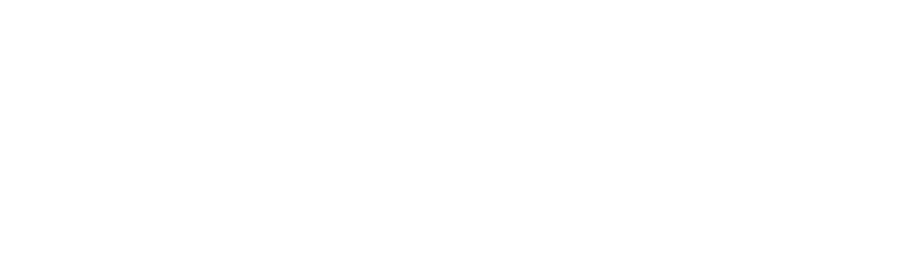

RMSE Error=5.56    r2=0.93    slope=0.75    Std_RMSE=0.57


gap filling for station Fagasa_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


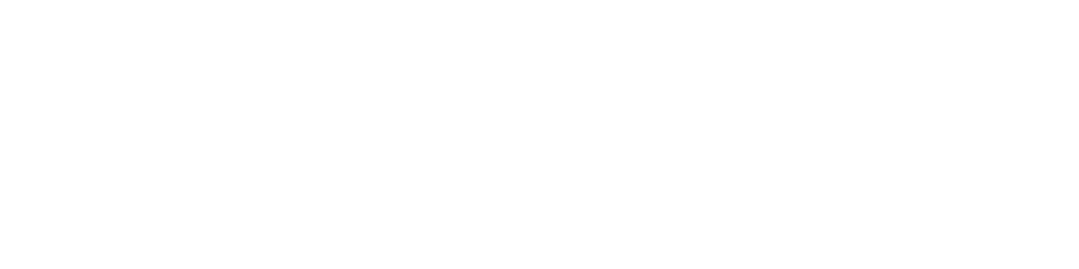

<IPython.core.display.Javascript object>


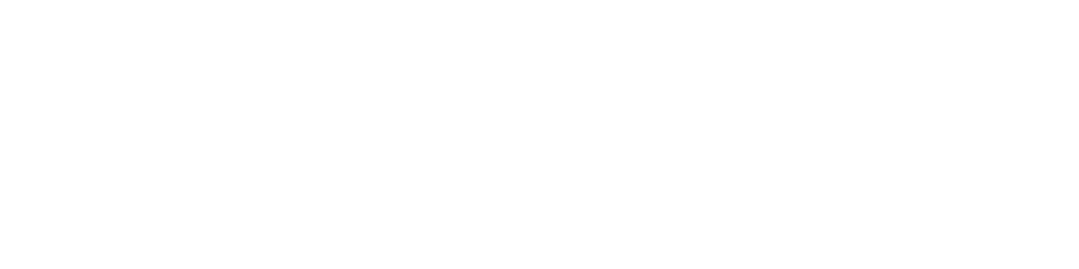

<IPython.core.display.Javascript object>


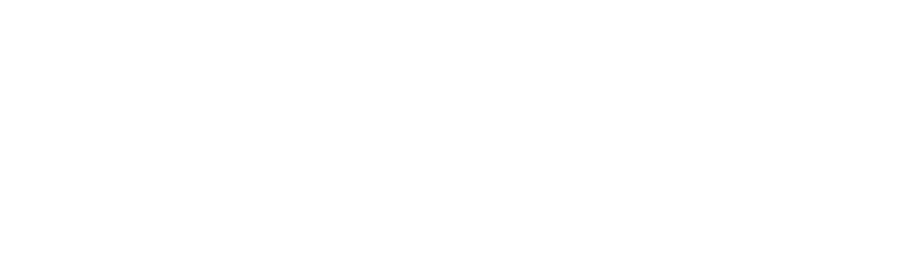

RMSE Error=6.03    r2=0.96    slope=0.51    Std_RMSE=1.16


gap filling for station Afono_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


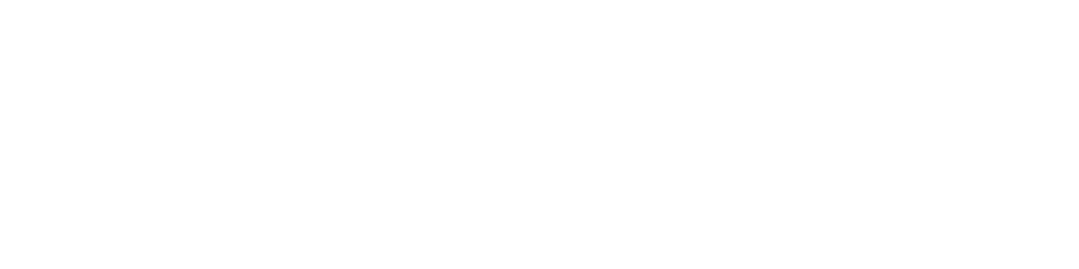

<IPython.core.display.Javascript object>


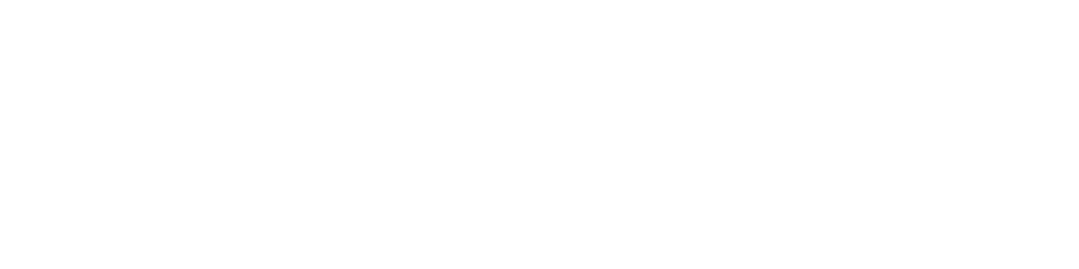

<IPython.core.display.Javascript object>


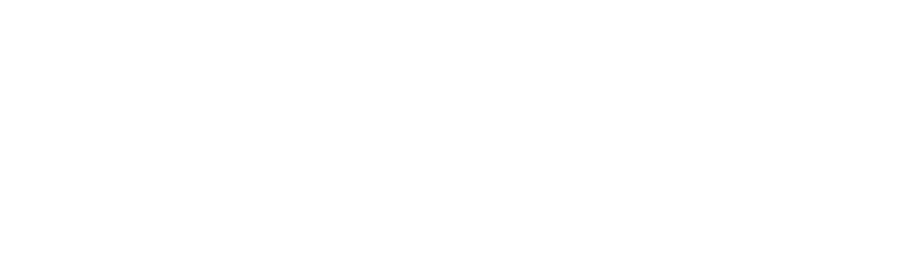

RMSE Error=7.20    r2=0.00    slope=0.00    Std_RMSE=5.03


Afono_CFS  Messed up dont know why:  RESTARTING LOOP!
gap filling for station Nuuuli_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


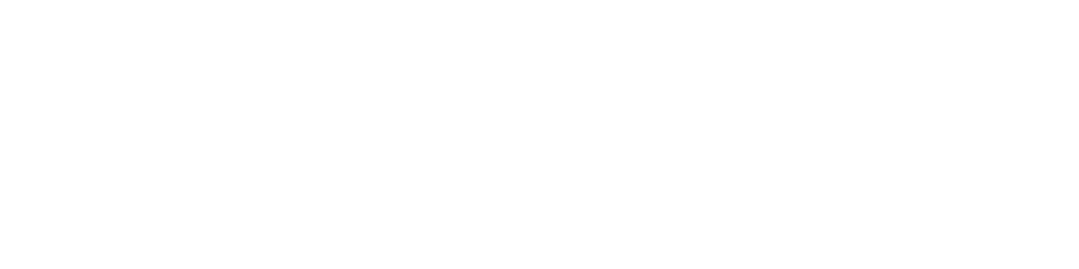

<IPython.core.display.Javascript object>


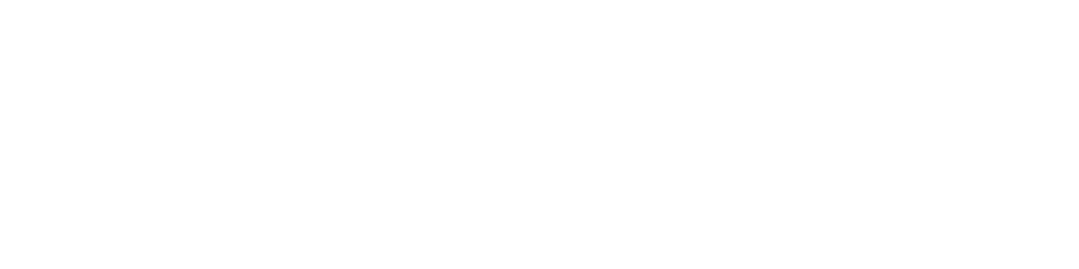

<IPython.core.display.Javascript object>


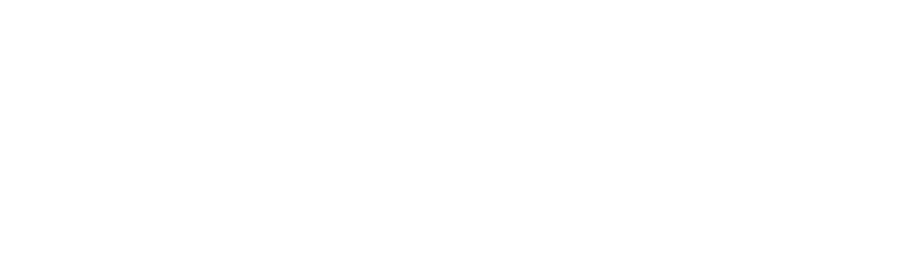

RMSE Error=4.25    r2=0.95    slope=0.77    Std_RMSE=0.72


gap filling for station Vaipito_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


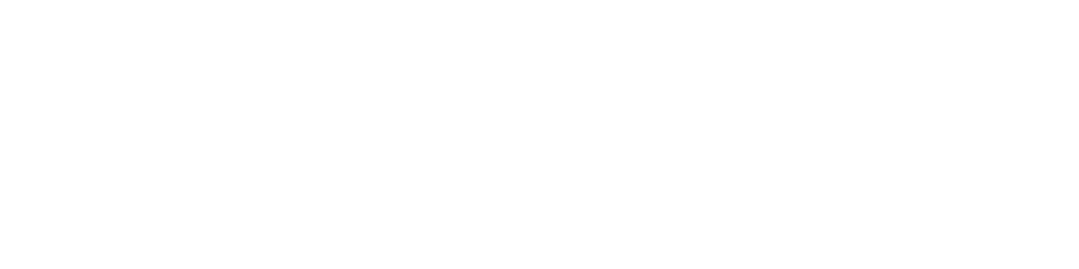

<IPython.core.display.Javascript object>


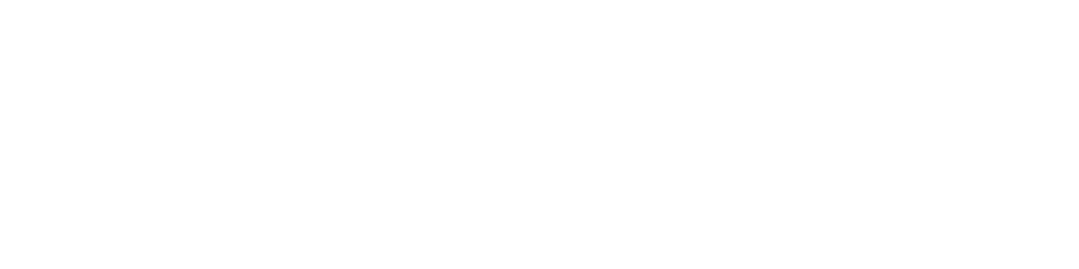

<IPython.core.display.Javascript object>


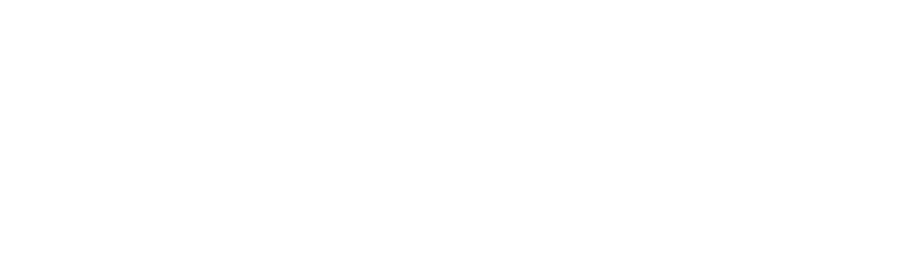

RMSE Error=3.60    r2=0.98    slope=0.77    Std_RMSE=0.59


gap filling for station Fagaitua_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS']


<IPython.core.display.Javascript object>


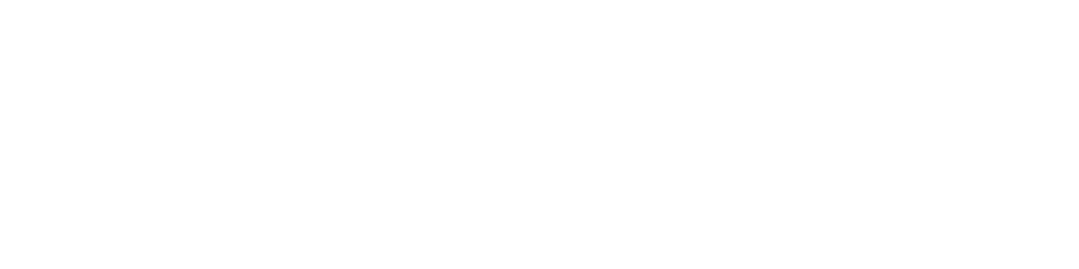

<IPython.core.display.Javascript object>


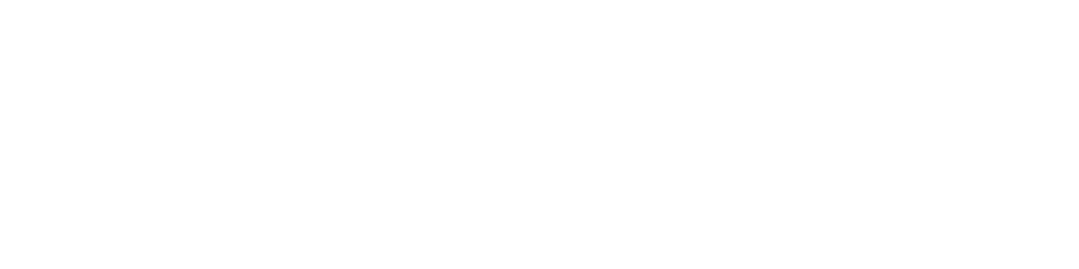

C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


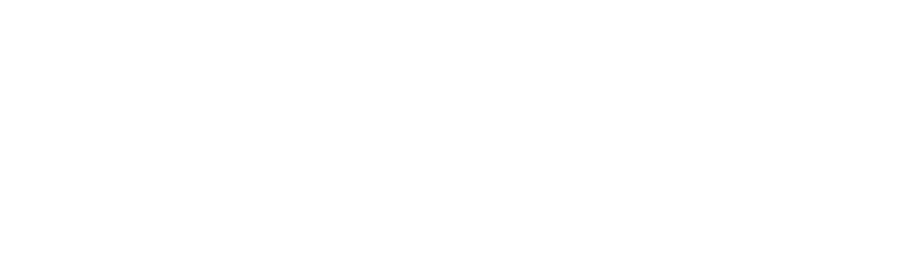

RMSE Error=0.57    r2=0.91    slope=0.68    Std_RMSE=0.73


gap filling for station Fagaalu_CFS
Training with stations ['Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


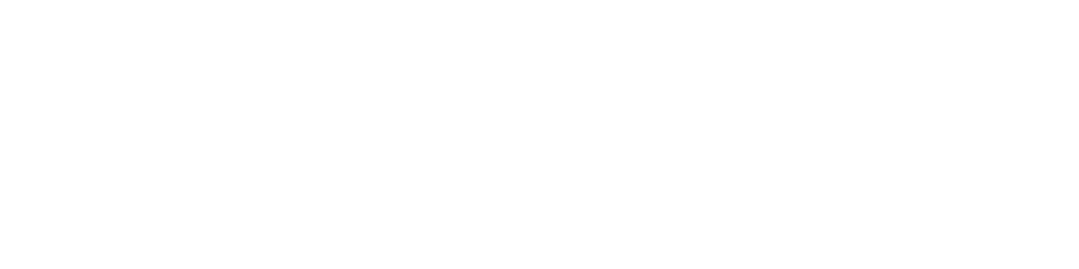

<IPython.core.display.Javascript object>


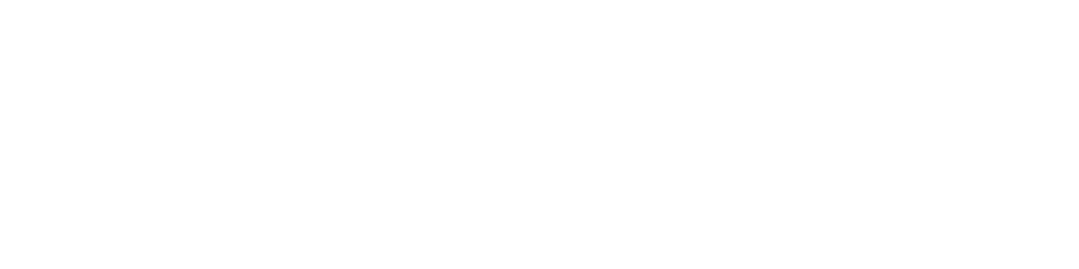

<IPython.core.display.Javascript object>


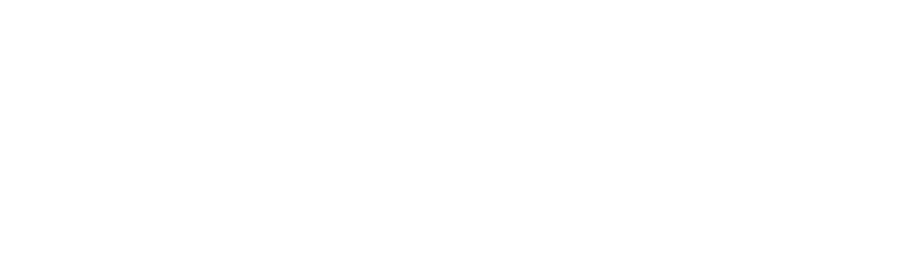

RMSE Error=5.47    r2=0.96    slope=0.77    Std_RMSE=0.54


gap filling for station Leone_CFS
Training with stations ['Fagaalu_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


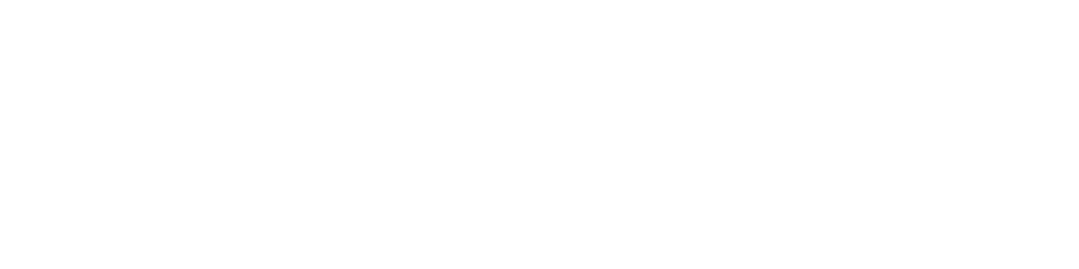

<IPython.core.display.Javascript object>


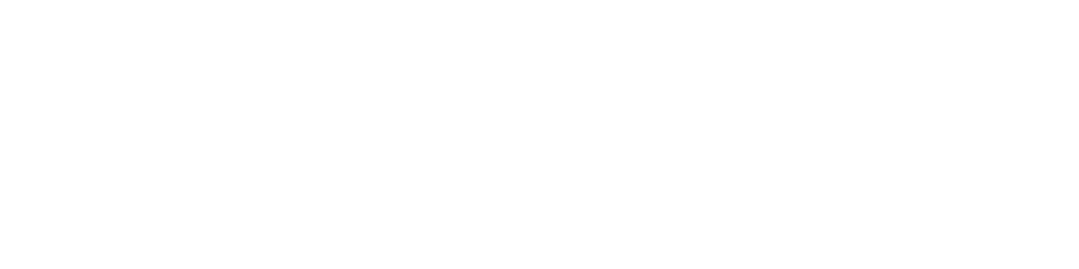

<IPython.core.display.Javascript object>


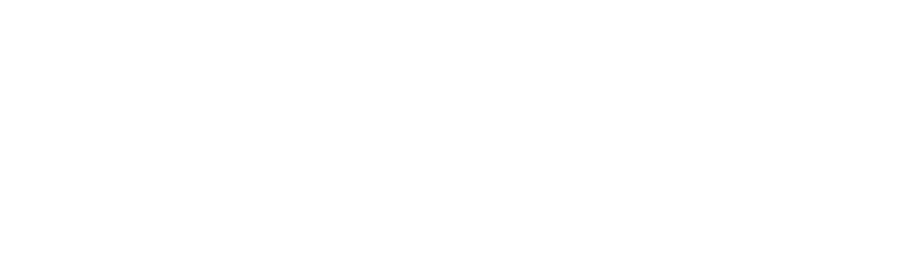

RMSE Error=5.82    r2=0.93    slope=0.72    Std_RMSE=0.60


gap filling for station Fagasa_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


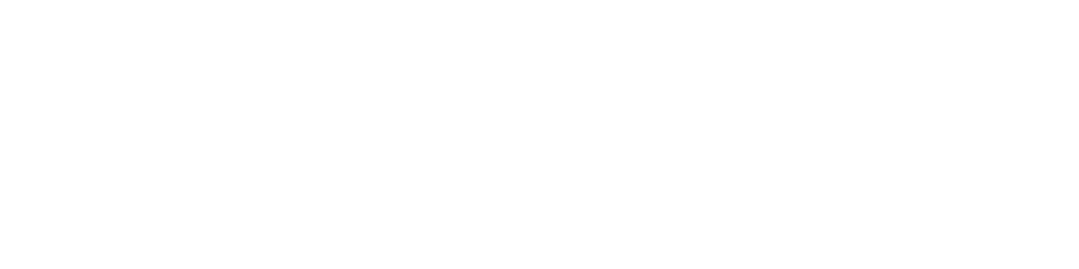

<IPython.core.display.Javascript object>


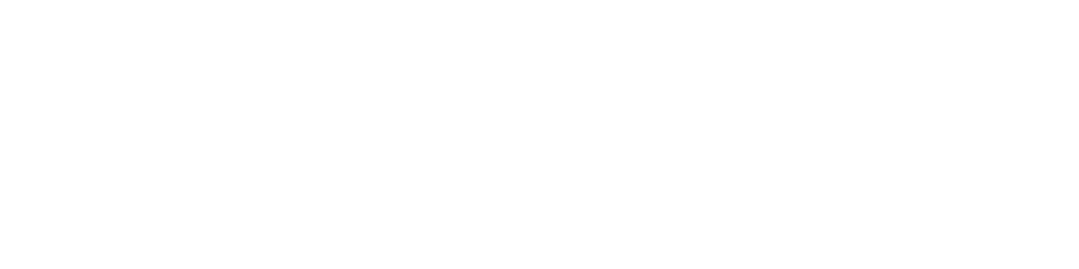

<IPython.core.display.Javascript object>


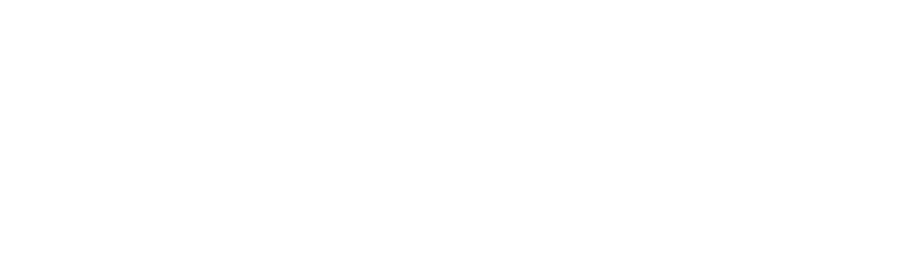

RMSE Error=3.93    r2=0.95    slope=0.78    Std_RMSE=0.67


gap filling for station Afono_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


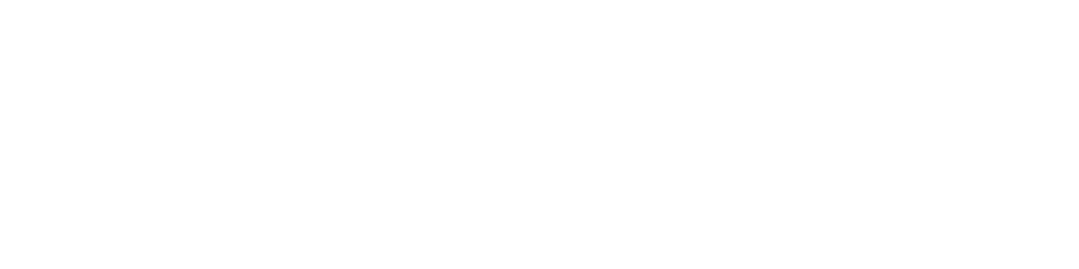

<IPython.core.display.Javascript object>


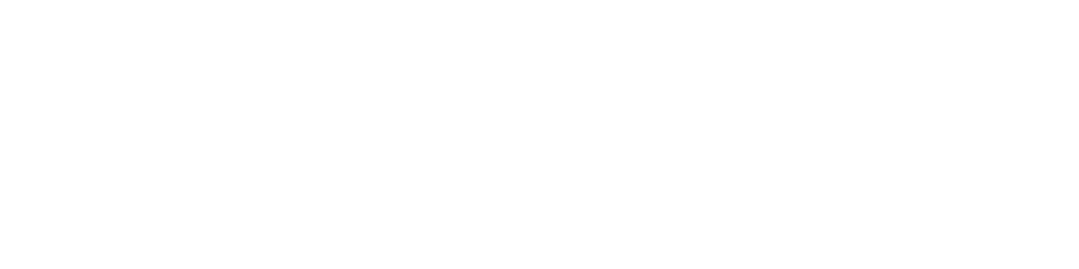

<IPython.core.display.Javascript object>


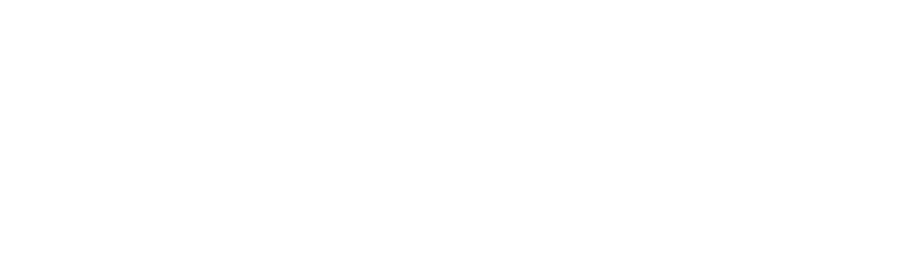

RMSE Error=2.52    r2=0.96    slope=1.07    Std_RMSE=0.72


gap filling for station Nuuuli_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


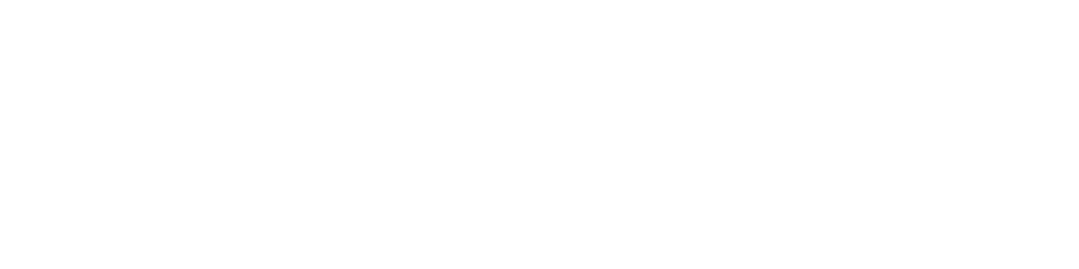

<IPython.core.display.Javascript object>


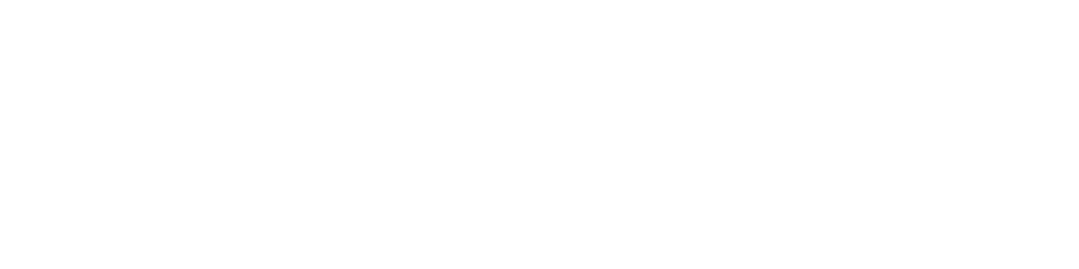

<IPython.core.display.Javascript object>


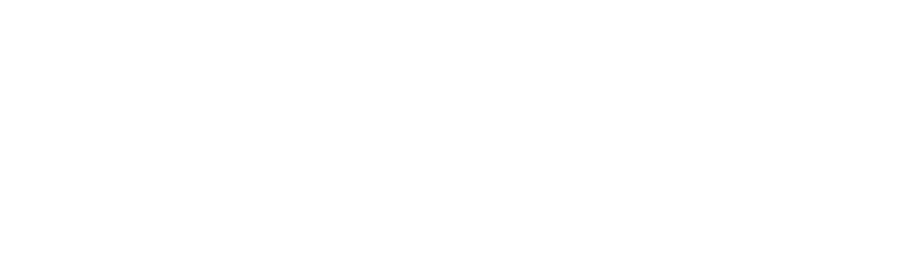

RMSE Error=4.23    r2=0.95    slope=0.77    Std_RMSE=0.72


gap filling for station Vaipito_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


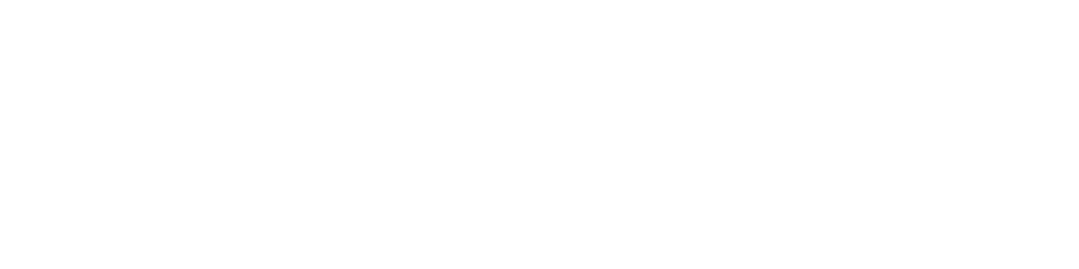

<IPython.core.display.Javascript object>


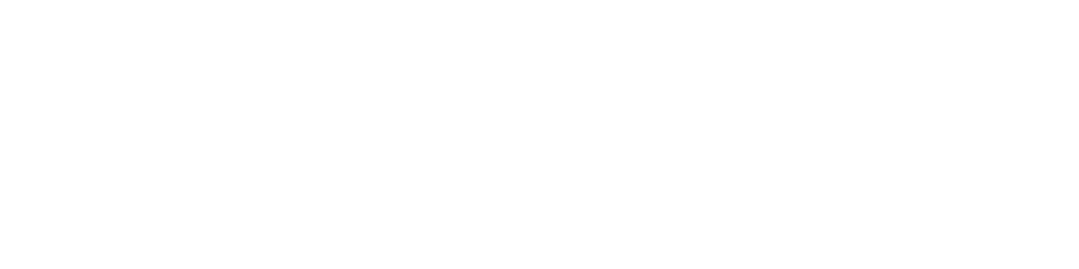

<IPython.core.display.Javascript object>


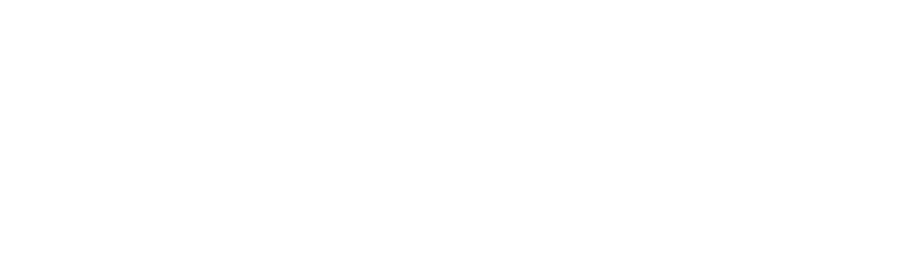

RMSE Error=3.63    r2=0.98    slope=0.76    Std_RMSE=0.61


gap filling for station Fagaitua_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS']


<IPython.core.display.Javascript object>


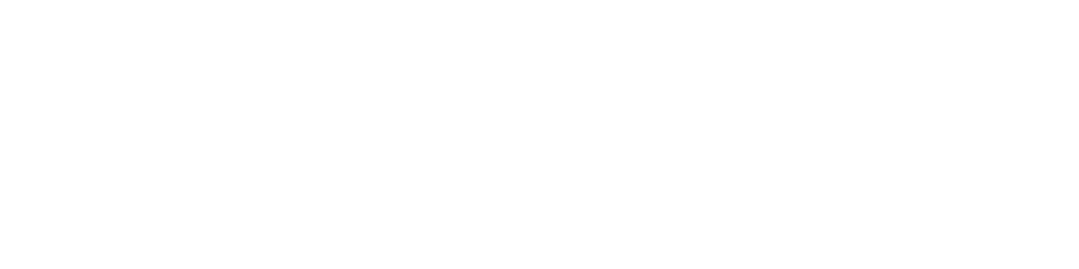

<IPython.core.display.Javascript object>


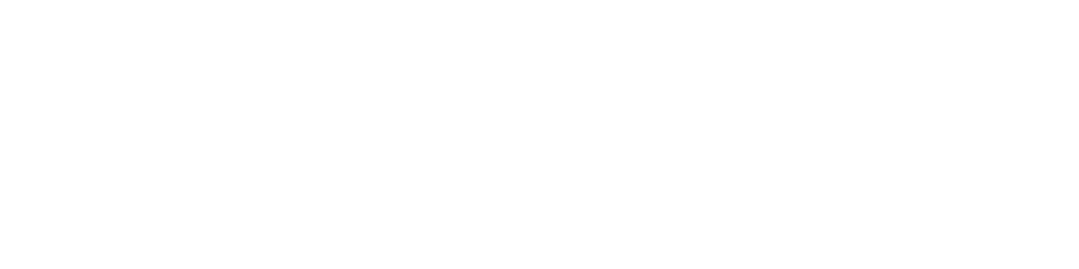

C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


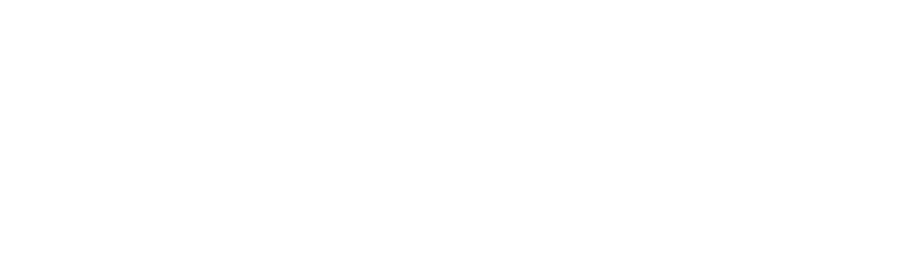

RMSE Error=1.46    r2=0.00    slope=0.00    Std_RMSE=3.14


Fagaitua_CFS  Messed up dont know why:  RESTARTING LOOP!
gap filling for station Fagaalu_CFS
Training with stations ['Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


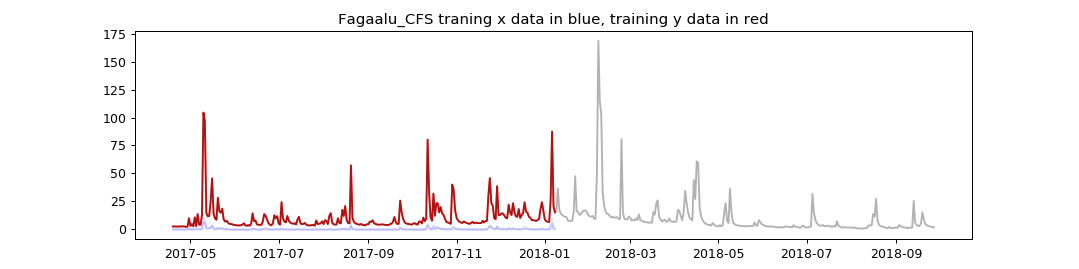

<IPython.core.display.Javascript object>


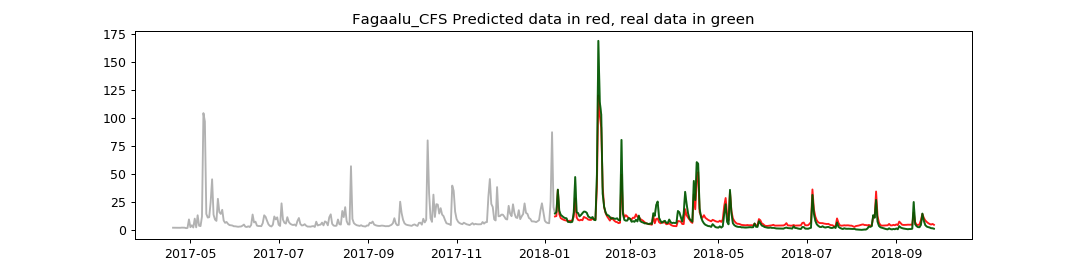

<IPython.core.display.Javascript object>


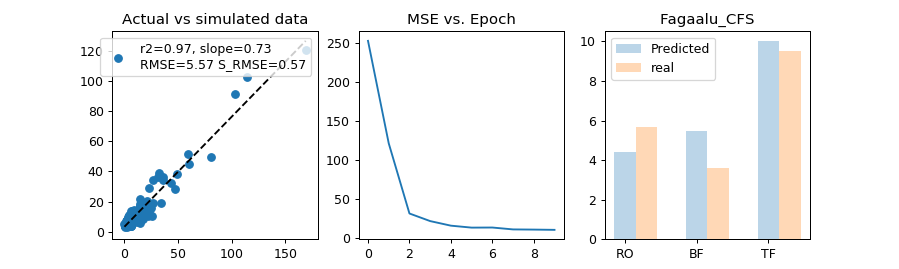

RMSE Error=5.57    r2=0.97    slope=0.73    Std_RMSE=0.57


gap filling for station Leone_CFS
Training with stations ['Fagaalu_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


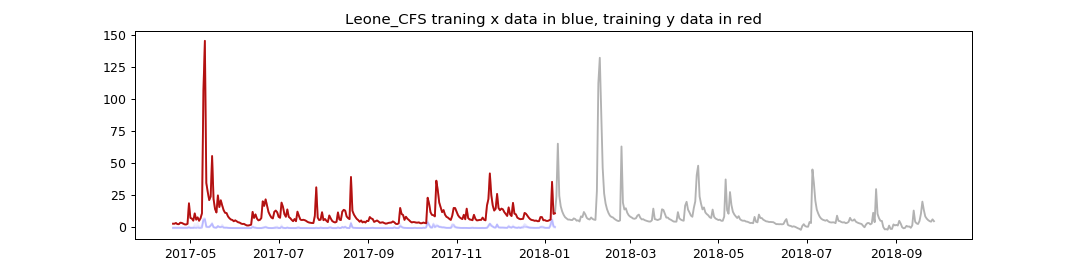

<IPython.core.display.Javascript object>


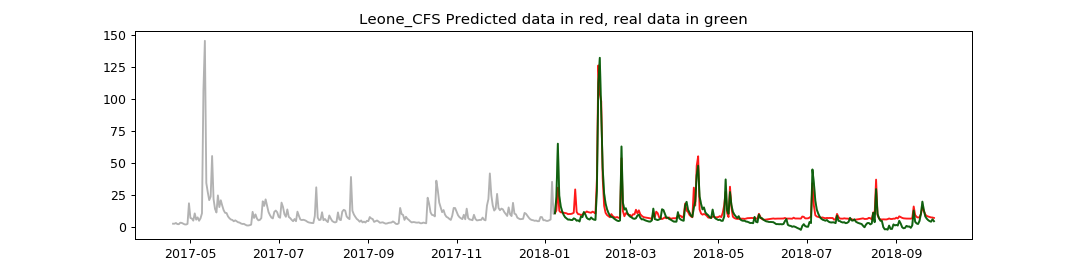

<IPython.core.display.Javascript object>


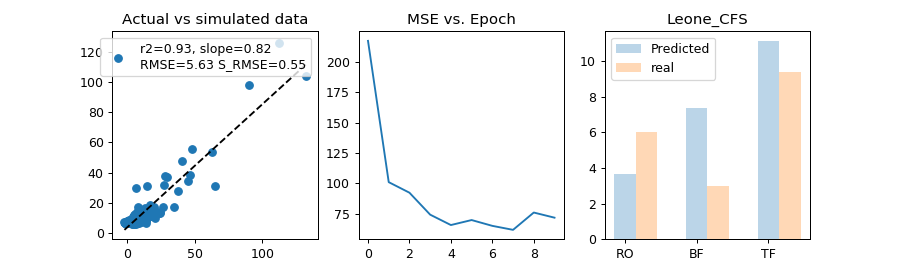

RMSE Error=5.63    r2=0.93    slope=0.82    Std_RMSE=0.55


gap filling for station Fagasa_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


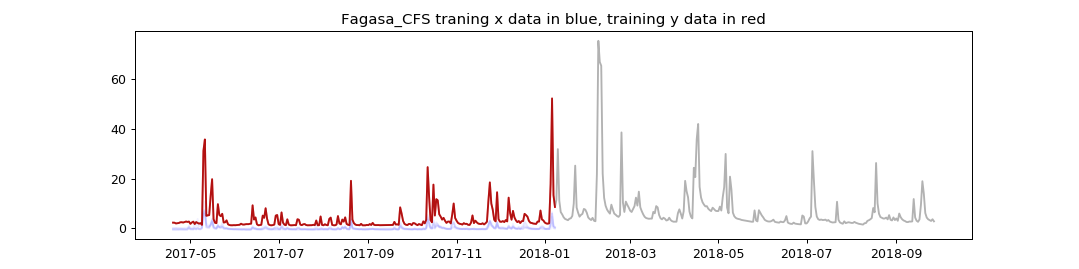

<IPython.core.display.Javascript object>


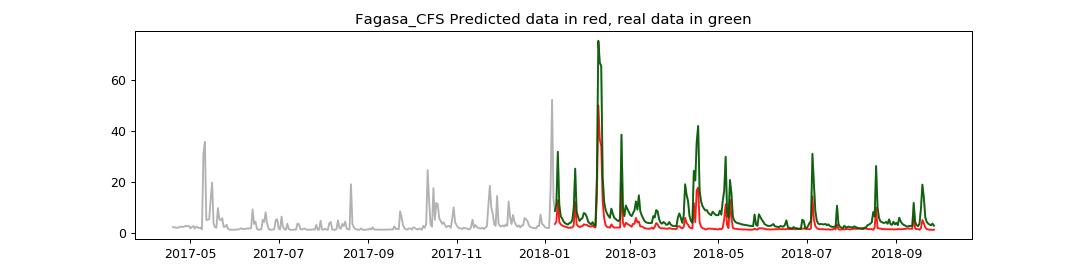

<IPython.core.display.Javascript object>


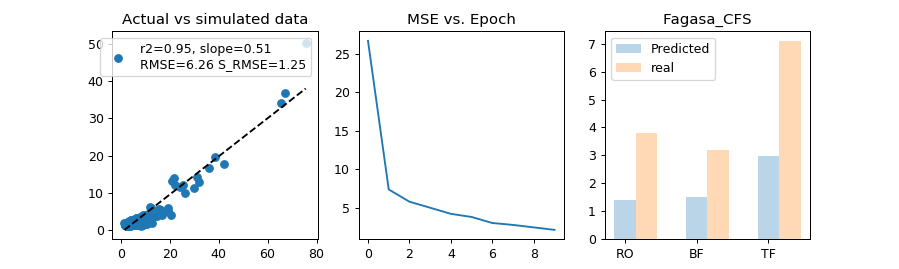

RMSE Error=6.26    r2=0.95    slope=0.51    Std_RMSE=1.25


gap filling for station Afono_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Nuuuli_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


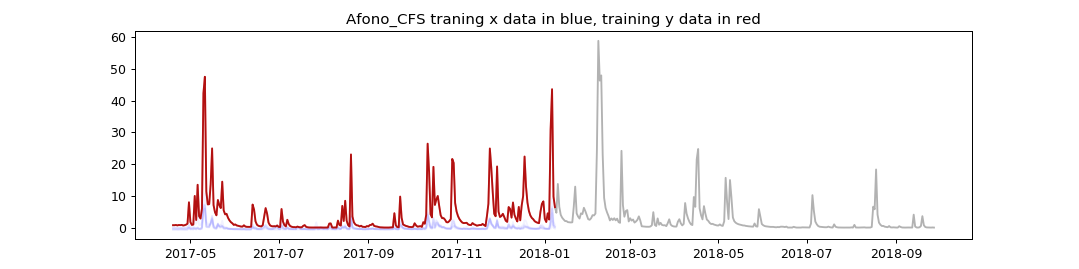

<IPython.core.display.Javascript object>


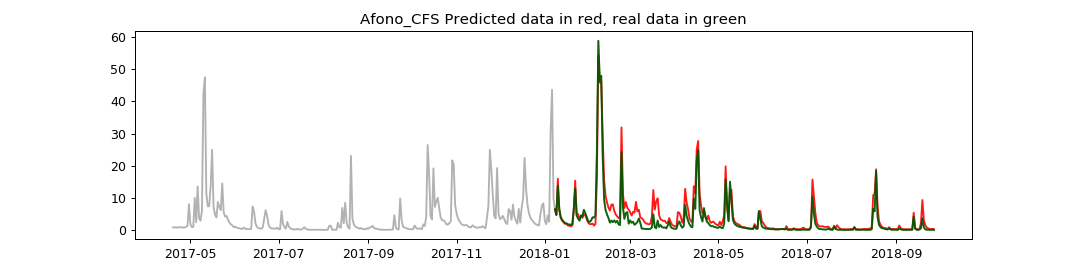

<IPython.core.display.Javascript object>


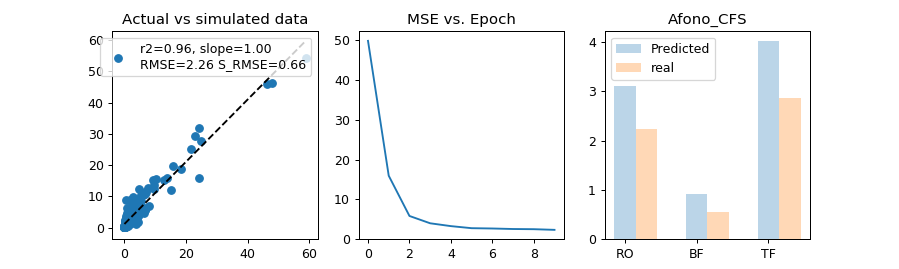

RMSE Error=2.26    r2=0.96    slope=1.00    Std_RMSE=0.66


gap filling for station Nuuuli_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


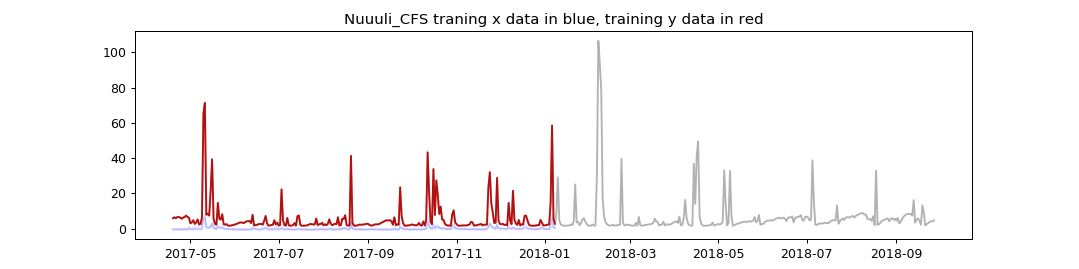

<IPython.core.display.Javascript object>


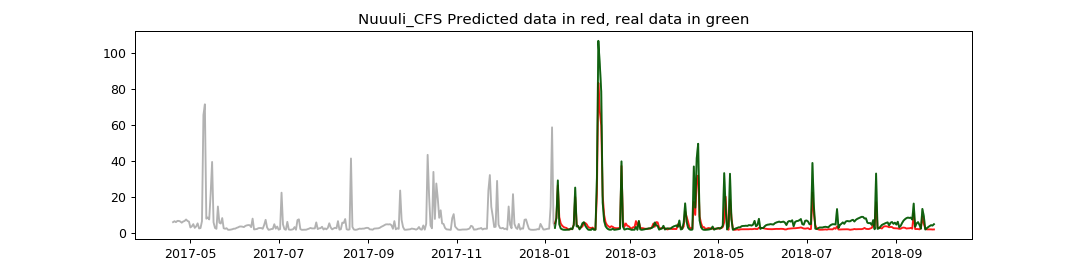

<IPython.core.display.Javascript object>


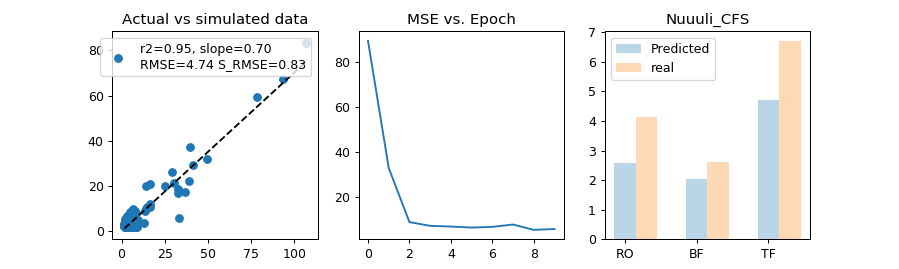

RMSE Error=4.74    r2=0.95    slope=0.70    Std_RMSE=0.83


gap filling for station Vaipito_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


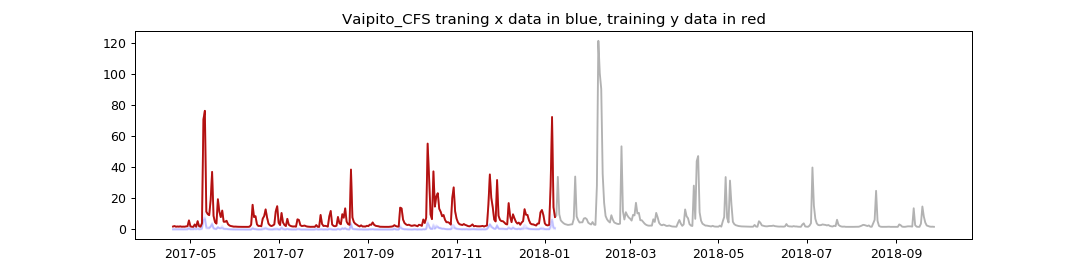

<IPython.core.display.Javascript object>


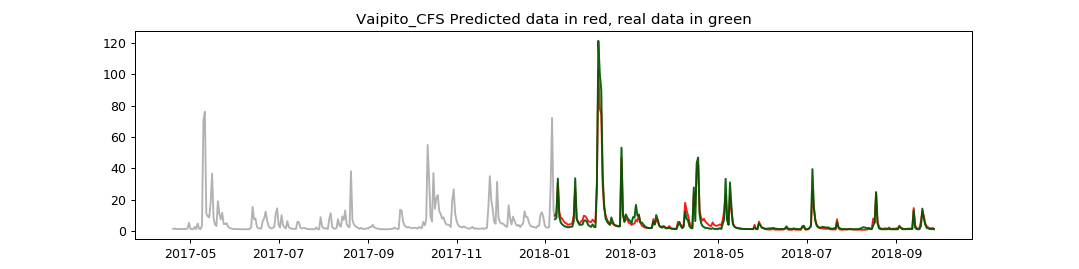

<IPython.core.display.Javascript object>


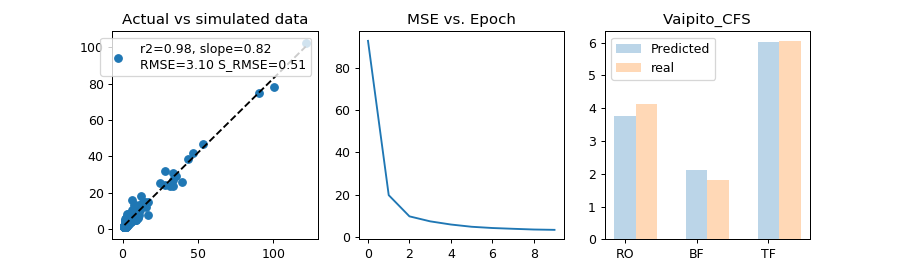

RMSE Error=3.10    r2=0.98    slope=0.82    Std_RMSE=0.51


gap filling for station Fagaitua_CFS
Training with stations ['Fagaalu_CFS', 'Leone_CFS', 'Fagasa_CFS', 'Afono_CFS', 'Nuuuli_CFS', 'Vaipito_CFS']


<IPython.core.display.Javascript object>


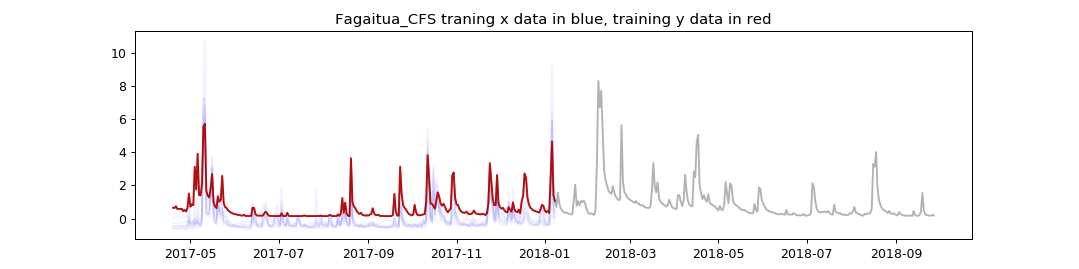

<IPython.core.display.Javascript object>


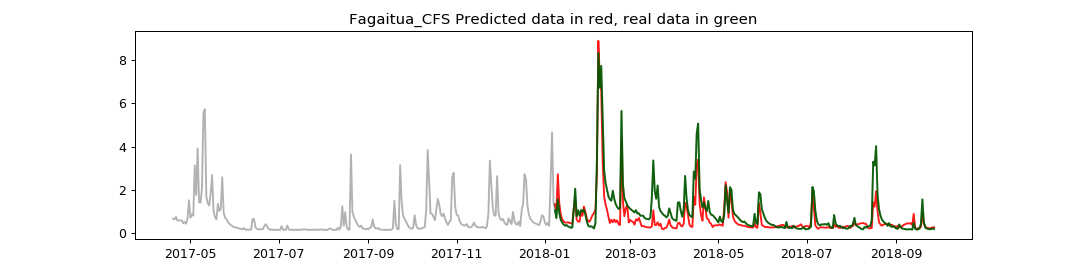

C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


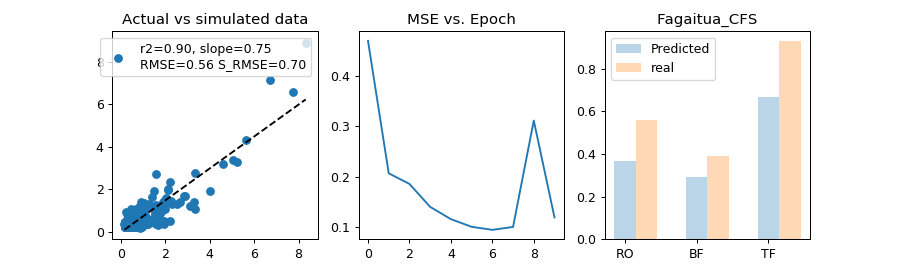

RMSE Error=0.56    r2=0.90    slope=0.75    Std_RMSE=0.70


OVERALL RMSE = 4.02
OVERALL Std_RMSE = 0.72
OVERALL r2 = 0.95
OVERALL Slope = 0.76
OVERALL %errRO = -0.24
OVERALL %errBF = -0.25
OVERALL %errTF = -0.28 


In [7]:
# output Plotting parameter (0 = no plots, 1 = summary plots, 2 = all plots)

plotlevel  = 2

station_list = list(data_perfect.columns)                        # all the stations to examine 

should_restart = True      # THIS WHILE LOOP WILL RESTART THE for loop if one of the stations fails (fail = slope is 0), then it will terminate once all the stations have completed without failing  
while should_restart:
    should_restart = False
    
    SRMSE_list=[]; slope_list=[];r2_list=[]; RMSE_list=[]; ROpErr_list=[]; BFpErr_list=[];  TFpErr_list=[]             # containers for the error statistics
    plt.close("all")  # close previous figures to clear memory
    
    for i in station_list:
        trainlist = list(data_perfect.columns.copy())                 # the list of all the other stations with which to use to train the network
        trainlist.remove(i)                        # remove the one station that is being gappped, all others are used for training
        print("gap filling for station {}".format(i));  print("Training with stations {}".format(trainlist))
        
        # select different portions of the dataset based on a % of data to "gap" off of the end of the validataion station
        n = len(data_perfect[i])  # total number of days in the perfect dataset
        how_much_to_delete = 1-Ave_amount_existing_data                      # Has to be   0 < x < 1  cant be 0 or 1. (delete the inverse of the %exsiting list)
        stop_idx = n-int((how_much_to_delete)*n)
        Train_End = data_perfect.index[stop_idx]                # end of the training data period, i.e. training data omits data after this data 
        Train_Start = data_perfect.index[0]                      # start of the training data period (always the beginning of data all 
        
        X_train = data_perfect.loc[Train_Start:Train_End,trainlist].values             
        y_train = data_perfect.loc[Train_Start:Train_End, i].values  
        
        #scale values appropriately
        scaler = StandardScaler().fit(X_train)   # Define the scaler 
        X_train = scaler.transform(X_train)      # Scale the train set
        
        # plot
        if plotlevel > 1:
            fig, ax = plt.subplots( figsize=(12, 3) )
            plt.plot(data_perfect.loc[Train_Start:Train_End].index, X_train, color='blue', alpha = .05)    # show the scaled y training data (note it is scaled so it is small)
            plt.plot(data_perfect.loc[Train_Start:Train_End].index, y_train, color='red', alpha = .9)     # show the unscaled y training data  (with the gap)
            plt.plot(data_perfect.index, data_perfect[i], color='k', alpha = .3)               # show the actual y data without the gap
            plt.title("{} traning x data in blue, training y data in red".format(i))
            
# DEEP netework go!            
        model = Sequential()
        model.add(Dense(20, activation='relu', input_shape=(len(trainlist),)))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(500, activation='relu'))
        model.add(Dense(1, activation='relu'))
        #model.summary()

        # train the network using data from the one station
        model.compile(optimizer='Nadam', loss='mse', metrics=['mse'])
        #model.compile(loss='mean_squared_error',  optimizer='Nadam',  metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=10, verbose=0)

# Prediction of virtual gaps GO!
        Predict_Start = data_perfect.index[(stop_idx)]                # Start of the validatiaon data period, = end of training data 
        Predict_End = data_perfect.index[-1]                          # end of the validation data period (always the end of data all)

        X_predict_known = data_perfect.loc[Predict_Start:Predict_End,trainlist].values 
        #scale values appropriately
        scaler = StandardScaler().fit(X_predict_known)   # Define the scaler 
        X_predict_known = scaler.transform(X_predict_known) # Scale the train set

        y_predict_unknown = model.predict(X_predict_known)
        y_predict_unknown = y_predict_unknown.reshape([np.shape(y_predict_unknown)[0]]).tolist()

        x = np.squeeze(data_perfect.loc[Predict_Start:Predict_End][i])               # the actual data from the staton that was gapped
        y = y_predict_unknown                                                        # the network generated data for the validation period   

        # plot
        if plotlevel > 1:
            fig, ax = plt.subplots( figsize=(12, 3) )
            plt.plot(data_perfect.loc[Predict_Start:Predict_End].index, y_predict_unknown, color='red', alpha = .9)     # show the unscaled y training data  (with the gap)
            plt.plot(data_perfect.loc[Predict_Start:Predict_End].index, x, color='green', alpha = .9)     # show the real test station data that was removed in the training
            plt.plot(data_perfect.index, data_perfect[i], color='k', alpha = .3)               # show the actual y data without the gap
            plt.title("{} Predicted data in red, real data in green".format(i))
            
        
# some stats on the regrassion between real and predicted values
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)                              # get stats on regression
        mea = np.mean(np.abs(x-y))
        rmse = np.sqrt(np.mean(np.abs(x-y)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
        Std_RMSE = rmse/((np.mean(x)+np.mean(y))/2)                                 # standardize the RMSE as a % of the mean

        
        # run a baseflow separation on the actual and predicted datasets to see how they compare
        Predict_date_vector = data_perfect.loc[Predict_Start:Predict_End].index 
        junk, RO_mean_predict,BF_mean_predict,TF_mean_predict  = baseflow_separator(Predict_date_vector, y_predict_unknown, False)
        junk, RO_mean_known, BF_mean_known, TF_mean_known      = baseflow_separator(Predict_date_vector, x, False)
        index = np.arange(3);  bar_width = 0.3   # just for plotting and offsetting the bars
        RO_pct_ERR = (RO_mean_predict-RO_mean_known)/RO_mean_known
        BF_pct_ERR = (BF_mean_predict-BF_mean_known)/BF_mean_known
        TF_pct_ERR = (TF_mean_predict-TF_mean_known)/TF_mean_known
        
        
        if plotlevel > 0:
            fig2, ax = plt.subplots(1, 3, figsize=(10, 3))
            ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
            ax[0].scatter(x, y, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
            ax[1].plot(history.history['mean_squared_error'])
            ax[0].set_title('Actual vs simulated data')
            ax[1].set_title('MSE vs. Epoch')

            # plot comparison of streamflows baseflow separated style
            ax[2].bar(index, (RO_mean_predict,BF_mean_predict, TF_mean_predict), width=bar_width, alpha=.3, label='Predicted')
            ax[2].bar(index+bar_width, (RO_mean_known,BF_mean_known, TF_mean_known), width=bar_width, alpha=.3, label='real')
            ax[2].set_xticklabels([None, "RO", "BF", "TF"])
            ax[2].set_title(i)
            plt.legend()
        
            # Label stats on dots plot
            ax[0].legend()
        
        #conpile lists of error statistics fpr analysis later
        SRMSE_list.append(Std_RMSE);   slope_list.append(slope);   r2_list.append(r_value)   ;RMSE_list.append(rmse)
        ROpErr_list.append(RO_pct_ERR);  BFpErr_list.append(BF_pct_ERR); TFpErr_list.append(TF_pct_ERR)
        
        print ('RMSE Error={:.2f}    r2={:.2f}    slope={:.2f}    Std_RMSE={:.2f}'.format(rmse, r_value, slope, Std_RMSE ))    
        print("\n")

        
        if slope == 0:                             # this terminates the loop if one of the trainings fails
            print(i +"  Messed up dont know why:  RESTARTING LOOP!")
            should_restart = True

# Print final statistics and metrics
print("OVERALL RMSE = {:.2f}\nOVERALL Std_RMSE = {:.2f}\nOVERALL r2 = {:.2f}\nOVERALL Slope = {:.2f}\nOVERALL %errRO = {:.2f}\nOVERALL %errBF = {:.2f}\nOVERALL %errTF = {:.2f} "
      .format(np.mean(RMSE_list),   np.mean(SRMSE_list), np.mean(r2_list), np.mean(slope_list), np.mean(ROpErr_list), np.mean(BF_pct_ERR), np.mean(TF_pct_ERR)  ))

In [ ]:
OVERALL RMSE = 4.03
OVERALL Std_RMSE = 0.71
OVERALL r2 = 0.95
OVERALL Slope = 0.74
OVERALL %errRO = -0.26
OVERALL %errBF = -0.13
OVERALL %errTF = -0.24 